In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

## Load Data
Define a function that imports all the data from the provided csv files

In [4]:
csv_paths = glob.glob("data/*.csv")
csv_filenames = [os.path.splitext(os.path.basename(x))[0] for x in csv_paths]

def load_data_from_csv():
    """Loads the csv files to pandas DataFrames and saves
    them in a dictionary with their filenames as keys"""
    data = dict()
    for csv_filename, csv_path in zip(csv_filenames, csv_paths):
        data[csv_filename] = pd.read_csv(csv_path)
    return data

# Load the data to a Dictionary
data = load_data_from_csv()

Inspect the data, the schema is shown below:

<img src="docs/schema.png">

First replace the chinese brands with their english names

In [6]:
# Join chinese brand names to their english equivalents
phone_brand_device_model = pd.merge(data["phone_brand_device_model"],
                                    data["chinese_to_english_brand"],
                                    left_on="phone_brand", right_on="chinese_brand", how="left")

# Fill nans for brands already in english
phone_brand_device_model["brand"] =\
    phone_brand_device_model["brand"].where(phone_brand_device_model["brand"].str.isalpha(),
                                                    phone_brand_device_model["phone_brand"].str.lower())

# We will just work with device brand and model for the time being
device_data = phone_brand_device_model[["device_id", "brand", "device_model"]]
device_data

,device_id,brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2
...,...,...,...
187240,7979541072208733273,xiaomi,MI 4
187241,-187404680852357705,xiaomi,红米2
187242,-2718274279595622821,xiaomi,MI 3
187243,3098391762071677791,vivo,X1


In [7]:
print(f'There are {len(device_data["device_id"].unique())} unique devices in the device data')
# Get rid of duplicates in the device data
device_data_cln = device_data.drop_duplicates("device_id")
print(len(device_data_cln))

There are 186716 unique devices in the device data
186716


There are 6 age group categories for each gender

In [8]:
data["gender_age_train"]["group"].sort_values().unique()

array(['F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+', 'M22-',
       'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'], dtype=object)

These categories already include the gender but for the purpose of this analysis we will create <br>
our own buckets use the actual age of the users to reduce the number of predicted classes

We'll proceed to join the device brand data to the train data

In [11]:
combined_data = data["gender_age_train"]
print(len(combined_data))
combined_data = pd.merge(combined_data, device_data_cln, on="device_id", how="left")
combined_data

74645


,device_id,gender,age,group,brand,device_model
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note
4,245133531816851882,M,30,M29-31,xiaomi,MI 3
...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3
74642,180946546684162312,M,20,M22-,xiaomi,红米note
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8


<AxesSubplot:>

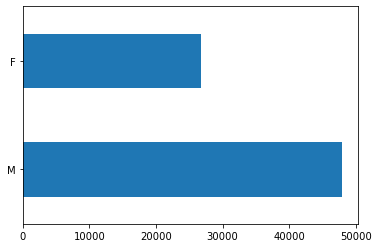

In [12]:
combined_data["gender"].value_counts().plot(kind='barh')

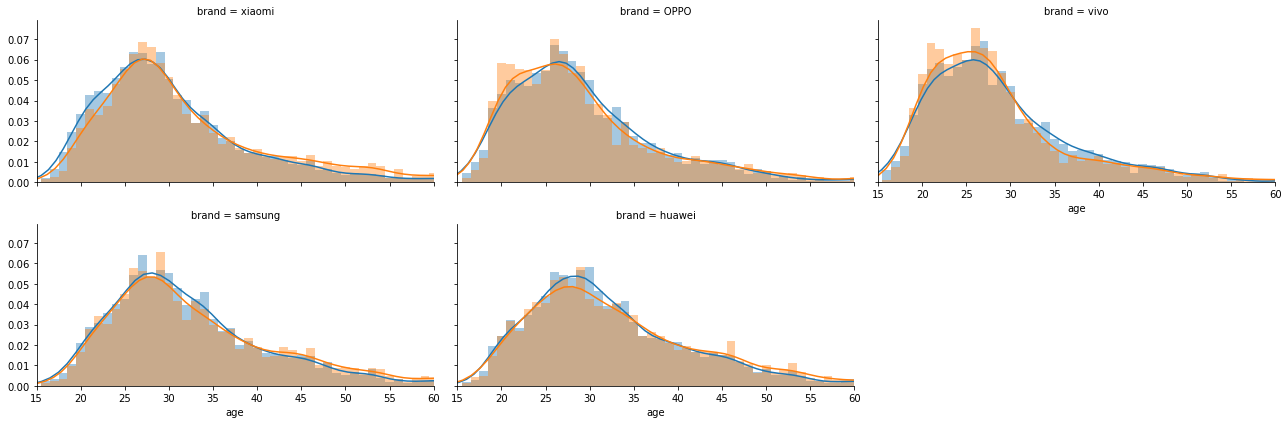

In [13]:
# Plot the gender distribution for the top 5 brands
brands = combined_data["brand"].value_counts().index[:5]
c = combined_data[combined_data["brand"].isin(brands)]
g = sns.FacetGrid(c, hue='gender', col='brand',col_wrap=3, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32418 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30021 missing from current f

C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32418 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31859 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 33635 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32768 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 30021 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LONAA32\Anaconda3\envs\tensorflow\li

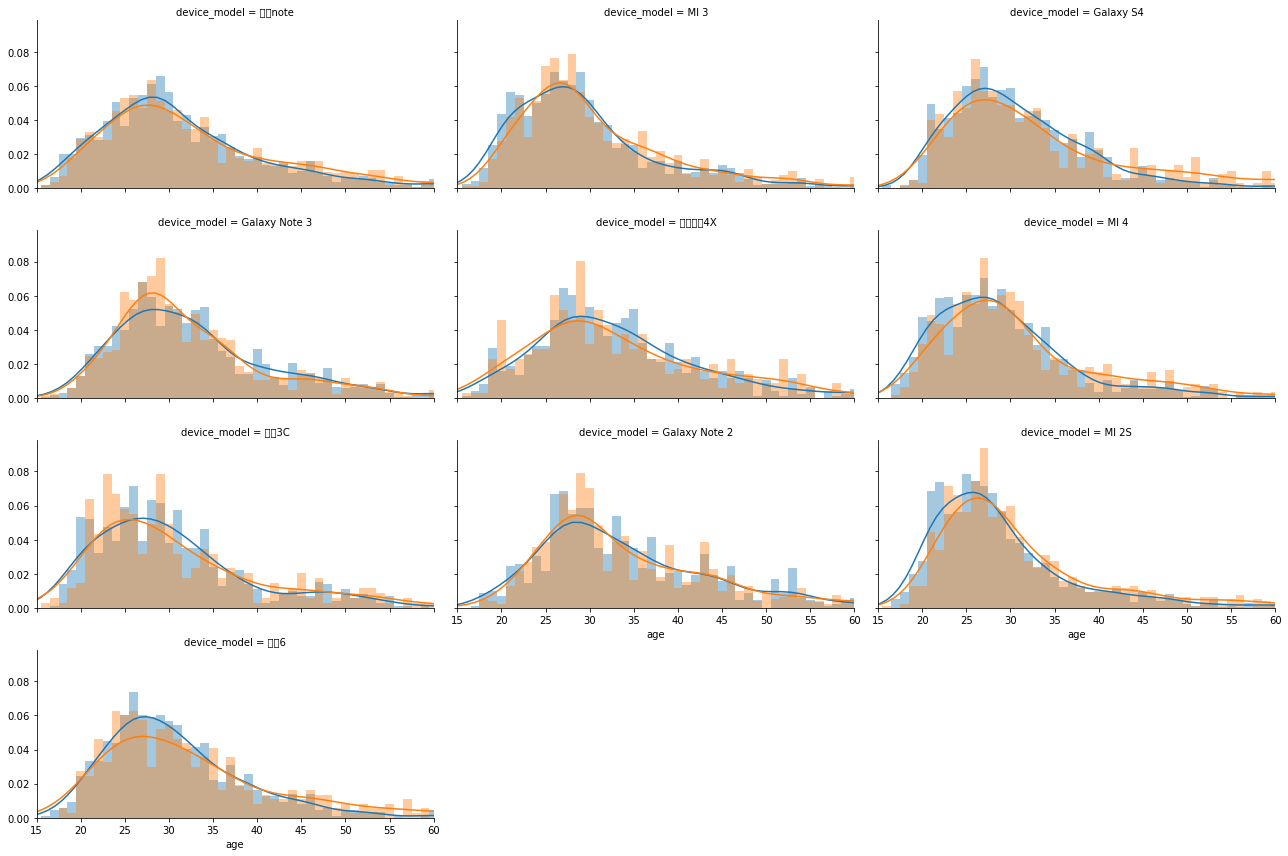

In [14]:
# Plot the gender distribution for the top 10 models
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
model = combined_data["device_model"].value_counts().index[:10]
c = combined_data[combined_data["device_model"].isin(model)]
g = sns.FacetGrid(c, hue='gender', col='device_model',col_wrap=3, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

# Approach 1

Since most of the devices do not have event data we will first attempt to infer gender and age using only the device brand and model data

In [90]:
from sklearn.preprocessing import LabelEncoder

In [112]:
FEATURE_COLUMNS = ["brand"]
LABELS = ["gender"]

# Prepare the labels
y = combined_data[LABELS]
#y = pd.get_dummies(y, prefix='', prefix_sep='')
le = LabelEncoder()
le.fit(y.to_numpy())
y_enc = le.transform(y)
y_enc

array([1, 1, 1, ..., 1, 1, 1])

In [96]:
# Prepare the features
X = combined_data[FEATURE_COLUMNS]
X = pd.get_dummies(X, prefix='', prefix_sep='')
X_enc = X.to_numpy()
X_enc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Split dataset into train, validation and test sets.

In [99]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

44787 train examples
14929 validation examples
14929 test examples


In [131]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(119,)),  # input shape required
])

In [132]:
predictions = model(X_train)
predictions[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.5027154 ],
       [0.54981244],
       [0.45413598],
       [0.5043206 ],
       [0.48577094]], dtype=float32)>

In [133]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [136]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [137]:
def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)


l = loss(model, X_train, y_train, training=False)
print("Loss test: {}".format(l))

ValueError: logits and labels must have the same shape ((44787, 1) vs (44787,))

In [117]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [118]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [121]:
loss_value, grads = grad(model, X_train, y_train)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, X_train, y_train, training=True).numpy()))

Step: 0, Initial Loss: 0.6853412985801697
Step: 1,Loss: 0.6847508549690247


In [124]:
def create_dataset(X, Y, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

In [125]:
## Note: Rerunning this cell uses the same model variables

num_epochs = 10
batch_size = 100

dataset = create_dataset(X_train, y_train, epochs=num_epochs, batch_size=batch_size)


# Keep results for plotting
train_loss_results = []
train_accuracy_results = []


for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.650, Accuracy: 64.095%
